In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishmotwani/tomato")

print("Path to dataset files:", path)

100%|██████████| 1.37G/1.37G [00:13<00:00, 106MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1


In [3]:
import os
import glob
import cv2
import numpy as np
import pathlib

In [4]:
SIZE = 180

In [5]:
input_dir = pathlib.Path(path)

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [30]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(input_dir,'train'),
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 25846 files belonging to 11 classes.


In [31]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(input_dir,'valid'),
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6681 files belonging to 11 classes.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']


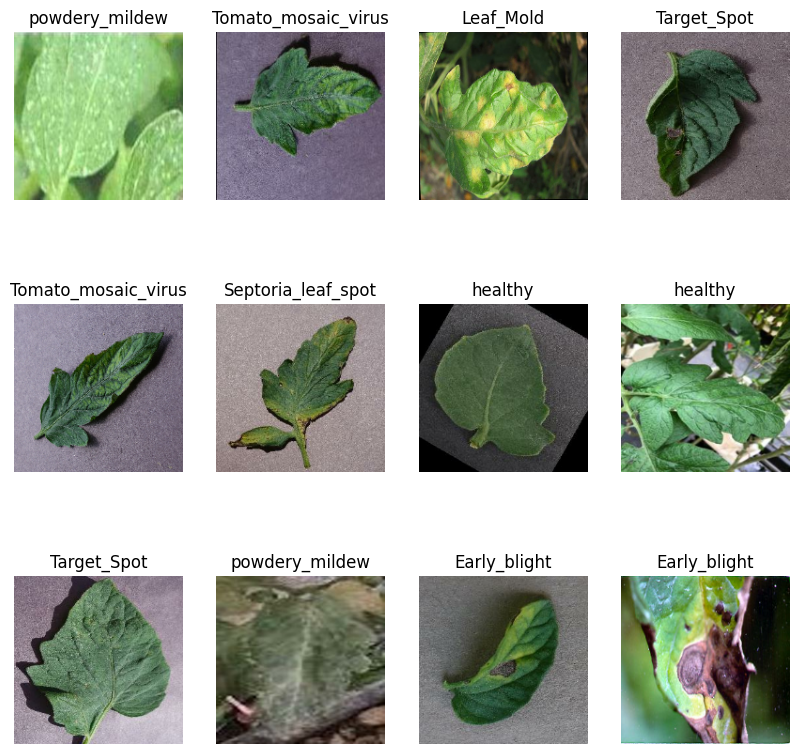

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape = (img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


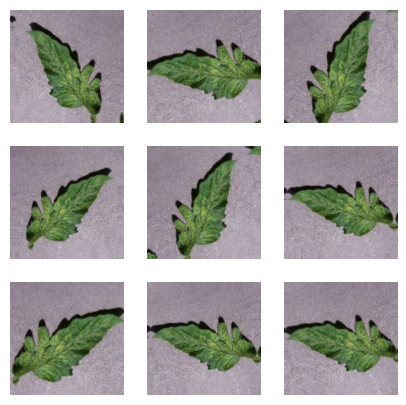

In [14]:
plt.figure(figsize=(5, 5))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [15]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,990,059 (15.22 MB)

 Trainable params: 3,990,059 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
808/808 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - accuracy: 0.7691 - loss: 0.6597 - val_accuracy: 0.7298 - val_loss: 0.8668
Epoch 2/15
808/808 ━━━━━━━━━━━━━━━━━━━━ 44s 55ms/step - accuracy: 0.8133 - loss: 0.5383 - val_accuracy: 0.7720 - val_loss: 0.8044
Epoch 3/15
808/808 ━━━━━━━━━━━━━━━━━━━━ 46s 57ms/step - accuracy: 0.8279 - loss: 0.4919 - val_accuracy: 0.8309 - val_loss: 0.4959
Epoch 4/15
808/808 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step - accuracy: 0.8466 - loss: 0.4333 - val_accuracy: 0.7797 - val_loss: 0.7744
Epoch 5/15
808/808 ━━━━━━━━━━━━━━━━━━━━ 81s 55ms/step - accuracy: 0.8653 - loss: 0.3873 - val_accuracy: 0.8307 - val_loss: 0.5072
Epoch 6/15
808/808 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - accuracy: 0.8749 - loss: 0.3553 - val_accuracy: 0.8740 - val_loss: 0.3782
Epoch 7/15
808/808 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - accuracy: 0.8863 - loss: 0.3354 - val_accuracy: 0.8883 - val_loss: 0.3572
Epoch 8/15
808/808 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - accuracy: 0.8878 - loss: 0.3217 - 

In [26]:
import os
import pathlib
import imghdr

def find_unsupported_files(directory):
    """Finds image files with unsupported formats in a directory.

    Args:
        directory: The directory to search.

    Returns:
        A list of unsupported file paths.
    """
    unsupported_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                # Check if the file is an image and its format
                img_type = imghdr.what(file_path)
                if img_type not in ['jpeg', 'png', 'gif', 'bmp']:
                    unsupported_files.append(file_path)
            except OSError:
                # File is likely not an image, ignore
                pass
    return unsupported_files

# Check both train and valid directories
input_dir = pathlib.Path(path)
unsupported_train_files = find_unsupported_files(os.path.join(input_dir, 'train'))
unsupported_valid_files = find_unsupported_files(os.path.join(input_dir, 'valid'))

if unsupported_train_files:
    print("Unsupported files in train directory:")
    for file_path in unsupported_train_files:
        print(file_path)

if unsupported_valid_files:
    print("Unsupported files in valid directory:")
    for file_path in unsupported_valid_files:
        print(file_path)

<ipython-input-26-e5fc2e525a97>:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Unsupported files in train directory:
/root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1/train/healthy/edible-tomato-leaves.jpg
/root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1/train/Leaf_Mold/BM_(6).jpg
/root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1/train/Leaf_Mold/607-155-1.jpg
/root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1/train/Leaf_Mold/BM_(7).jpg
/root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1/train/Early_blight/EB_(976).jpg
Unsupported files in valid directory:
/root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1/valid/healthy/2013-08-20-05.jpg
/root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1/valid/Leaf_Mold/607-155-0.jpg


In [27]:
import os
import pathlib
import imghdr

def find_and_remove_unsupported_files(directory):
    """Finds and removes image files with unsupported formats in a directory.

    Args:
        directory: The directory to search.
    """
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                # Check if the file is an image and its format
                img_type = imghdr.what(file_path)
                if img_type not in ['jpeg', 'png', 'gif', 'bmp']:
                    os.remove(file_path)  # Remove the unsupported file
                    print(f"Removed unsupported file: {file_path}")
            except OSError:
                # File is likely not an image, ignore
                pass

# Check both train and valid directories
input_dir = pathlib.Path(path)
find_and_remove_unsupported_files(os.path.join(input_dir, 'train'))
find_and_remove_unsupported_files(os.path.join(input_dir, 'valid'))

# Now you can continue with your code to load the dataset and train the model:
# ... (rest of your code)

Removed unsupported file: /root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1/train/healthy/edible-tomato-leaves.jpg
Removed unsupported file: /root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1/train/Leaf_Mold/BM_(6).jpg
Removed unsupported file: /root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1/train/Leaf_Mold/607-155-1.jpg
Removed unsupported file: /root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1/train/Leaf_Mold/BM_(7).jpg
Removed unsupported file: /root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1/train/Early_blight/EB_(976).jpg
Removed unsupported file: /root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1/valid/healthy/2013-08-20-05.jpg
Removed unsupported file: /root/.cache/kagglehub/datasets/ashishmotwani/tomato/versions/1/valid/Leaf_Mold/607-155-0.jpg


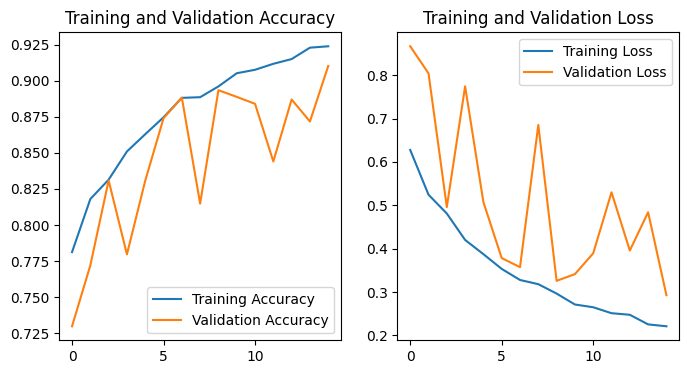

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


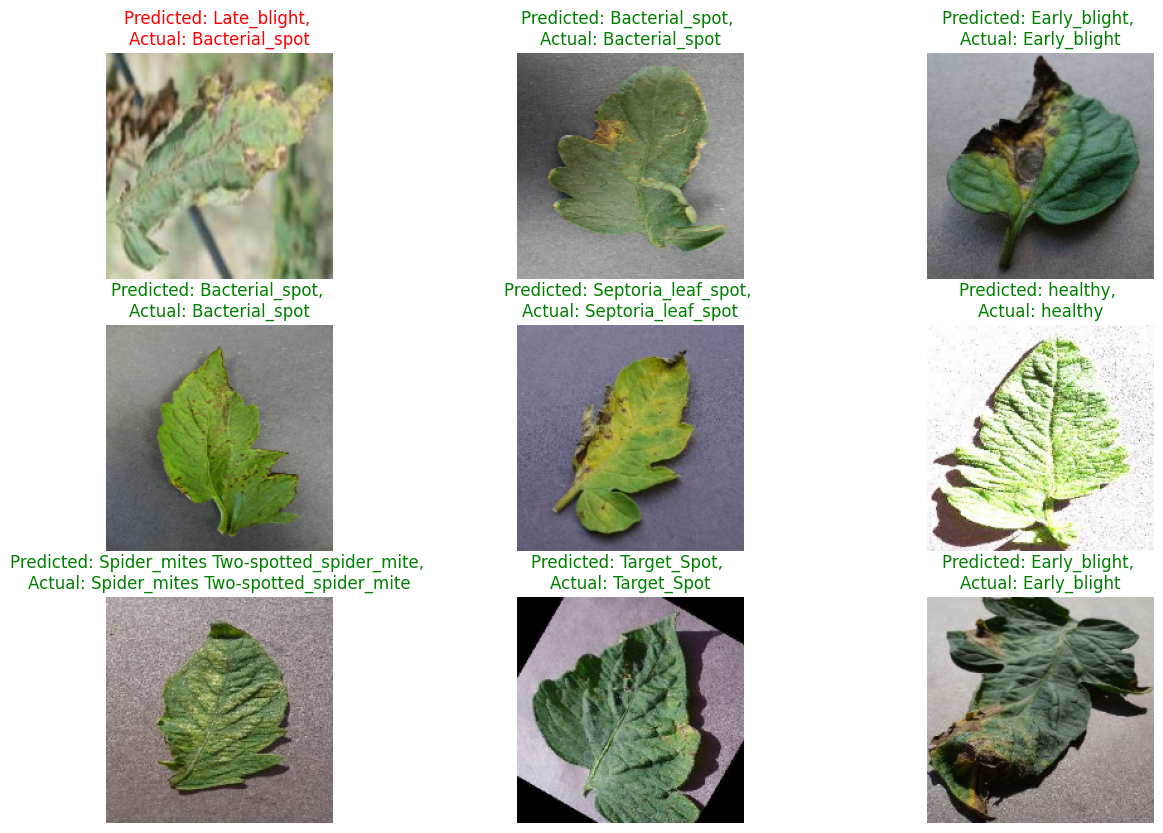

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    prediction = model.predict(images)
    ax = plt.subplot(3, 3, i+1)
    predicted_label = class_names[tf.argmax(prediction[i])] # get prediction for current image
    actual_label = class_names[labels[i]]
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Predicted: {predicted_label}, \nActual: {actual_label}",
              color = "green" if predicted_label == actual_label else "red")
    plt.axis("off")
